<a target="_blank" href="https://colab.research.google.com/github/kurchi1205/ERA-S12-Assignment/blob/main/training.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [1]:
!pip install pytorch-lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 722.8/722.8 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.1/731.1 kB 59.5 MB/s eta 0:00:00


In [2]:
%pip install albumentations

In [3]:
!pip uninstall -y opencv-python
!conda install glib=2.51.0 -y
!pip install opencv-python
!pip install opencv-python-headless

Found existing installation: opencv-python 4.7.0.72
Uninstalling opencv-python-4.7.0.72:
  Successfully uninstalled opencv-python-4.7.0.72
/bin/bash: line 1: conda: command not found
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.7/61.7 MB 12.5 MB/s eta 0:00:00


In [4]:
import os

# Define the repository and the target directory
repo_url = 'https://github.com/kurchi1205/ERA-S12-Assignment'
target_dir = '/content/era_s12'

# Check if the directory already exists
if not os.path.exists(target_dir):
    # If it doesn't exist, clone the repo
    !git clone {repo_url} {target_dir}
else:
    # If it exists, 'cd' into the directory and pull the latest changes
    %cd {target_dir}
    !git pull
    %cd ..

# Add the repository's directory to the system path
import sys
sys.path.append(target_dir)


Cloning into '/content/era_s12'...
remote: Enumerating objects: 37, done.
remote: Counting objects: 100% (37/37), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 37 (delta 17), reused 25 (delta 8), pack-reused 0
Receiving objects: 100% (37/37), 40.93 KiB | 3.41 MiB/s, done.
Resolving deltas: 100% (17/17), done.


In [17]:
from data import CIFAR10LitModule
from train_lightning import LitResnet
import os
import torch
from pytorch_lightning import LightningModule, Trainer
from pytorch_lightning.loggers import CSVLogger



In [6]:
AVAIL_GPUS = min(1, torch.cuda.device_count())
BATCH_SIZE = 256 if AVAIL_GPUS else 64
AVAIL_GPUS

1

In [40]:
# init Dataloader from MNIST Dataloader
ds = CIFAR10LitModule(batch_size=BATCH_SIZE)
ds.setup()
train_loader = ds.train_dataloader()
val_loader = ds.val_dataloader()
resnet_model = LitResnet(0.01)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [21]:
from pytorch_lightning.callbacks import ModelCheckpoint
class CustomModelCheckpoint(ModelCheckpoint):
    def __init__(self, **kwargs):
      super().__init__(**kwargs)
      self.best_val_acc = 0
    def on_validation_epoch_end(self, trainer, pl_module):
        current_val_acc = trainer.callback_metrics.get("val_acc", None)
        if current_val_acc is None:
            # If val_acc is not available, you can use any other validation metric you have defined
            # For example, if your validation metric is named "validation_metric", use:
            # current_val_acc = trainer.callback_metrics.get("validation_metric", None)
            raise ValueError("Validation accuracy (val_acc) not found in metrics.")

        if current_val_acc >= self.best_val_acc:
            self.best_val_acc = current_val_acc
            state_dict = pl_module.state_dict()
            checkpoint_path = f"{self.dirpath}/model_epoch_{trainer.current_epoch}.pth"
            torch.save(state_dict, checkpoint_path)


In [41]:
# initialize the trainer
checkpoint_callback = CustomModelCheckpoint(dirpath="./",
    monitor="val_acc",
    save_top_k=1,
    mode="max",
)
trainer = Trainer(
    accelerator="auto",
    max_epochs = 20,
    logger=CSVLogger(save_dir="logs/"),
    callbacks=[checkpoint_callback]
)

# Train the model
trainer.fit(resnet_model, train_loader, val_loader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:615: UserWarning: Checkpoint directory /content exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loading `train_dataloader` to estimate number of stepping batches.
INFO:pytorch_lightning.callbacks.model_summary:
  | Name     | Type               | Params
------------------------------------------------
0 | model    | Net                | 6.6 M 
1 | loss_fn  | CrossEntropyLoss   | 0     
2 | accuracy | Mult

Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:480: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


In [15]:
import matplotlib.pyplot as plt
def plot_losses(train_losses, test_losses, train_acc, test_acc):
    fig, axs = plt.subplots(2,2,figsize=(15,10))
    t = [t_items.item() for t_items in train_losses]
    axs[0, 0].plot(t)
    axs[0, 0].set_title("Training Loss")
    t = [t_items.item() for t_items in train_acc]
    axs[1, 0].plot(t)
    axs[1, 0].set_title("Training Accuracy")
    t = [t_items.item() for t_items in train_acc]
    axs[0, 1].plot(t)
    axs[0, 1].set_title("Test Loss")
    t = [t_items.item() for t_items in train_acc]
    axs[1, 1].plot(t)
    axs[1, 1].set_title("Test Accuracy")

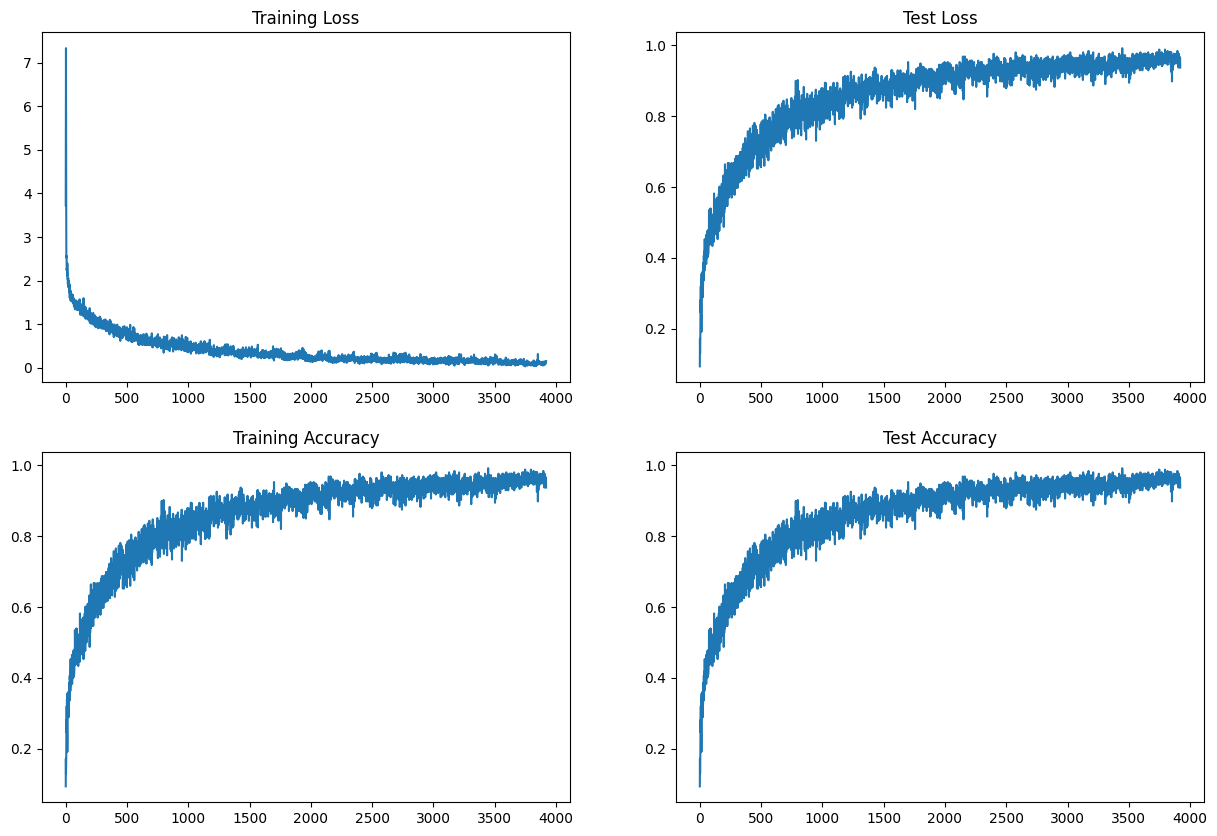

In [42]:
plot_losses(resnet_model.train_losses, resnet_model.val_losses, resnet_model.train_acc, resnet_model.val_acc)